# Sales Forecasting Pipeline using Prophet

In [4]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
train = pd.read_csv("train.csv", parse_dates=["Date"])
store = pd.read_csv("store.csv")

/tmp/ipython-input-3429630992.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("train.csv", parse_dates=["Date"])


In [6]:
df = pd.merge(train, store, on="Store", how="left")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567 no

In [7]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [8]:
df = df[(df["Open"] == 1) & (df["Sales"] > 0)]


## Filling missing values

In [9]:
df["CompetitionDistance"].fillna(df["CompetitionDistance"].median(), inplace=True)
df["CompetitionOpenSinceMonth"].fillna(df["CompetitionOpenSinceMonth"].mode()[0], inplace=True)
df["CompetitionOpenSinceYear"].fillna(df["CompetitionOpenSinceYear"].mode()[0], inplace=True)
df["Promo2SinceWeek"].fillna(0, inplace=True)
df["Promo2SinceYear"].fillna(0, inplace=True)
df["PromoInterval"].fillna("None", inplace=True)


/tmp/ipython-input-1036275814.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["CompetitionDistance"].fillna(df["CompetitionDistance"].median(), inplace=True)
/tmp/ipython-input-1036275814.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].me

In [10]:
store_id = 1
store_df = df[df["Store"] == store_id]

In [11]:
prophet_df = store_df[["Date", "Sales"]].rename(columns={"Date": "ds", "Sales": "y"})


In [12]:
model = Prophet(daily_seasonality=False, yearly_seasonality=True, weekly_seasonality=True)
model.fit(prophet_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpnb5liw_7/x3a9a8h0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnb5liw_7/k2stwrvw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20495', 'data', 'file=/tmp/tmpnb5liw_7/x3a9a8h0.json', 'init=/tmp/tmpnb5liw_7/k2stwrvw.json', 'output', 'file=/tmp/tmpnb5liw_7/prophet_modelelfsfeq_/prophet_model-20250805100355.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:03:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:03:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [13]:
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

### Store 1 Forecast
This plot shows the sales forecast for Store 1, including the historical data points and the predicted trend with uncertainty intervals.

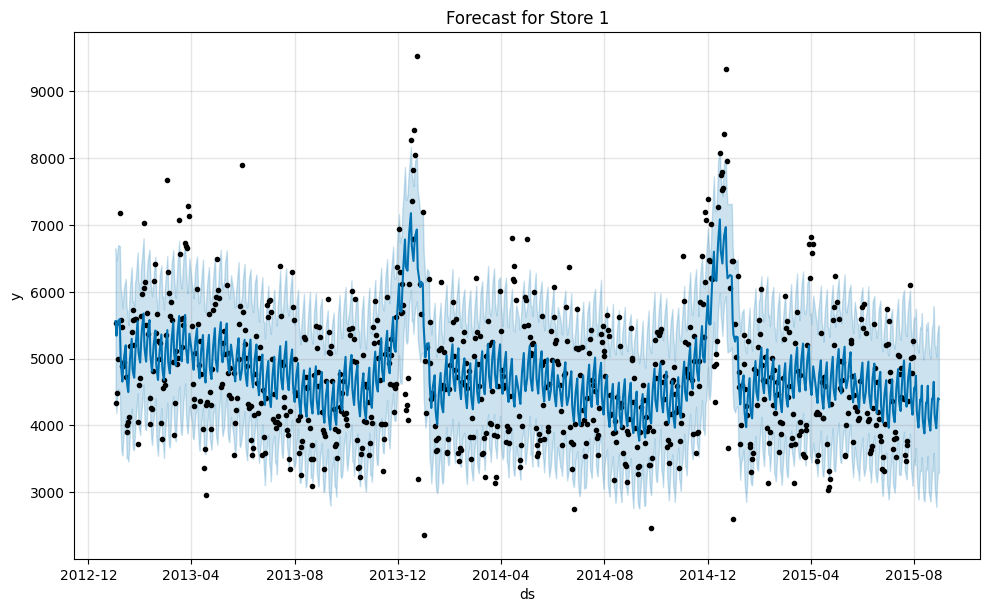

In [14]:
model.plot(forecast)
plt.title(f"Forecast for Store {store_id}")
plt.show()


In [15]:
# Choose cutoff date to split train and test
cutoff_date = prophet_df['ds'].max() - pd.Timedelta(days=26)

# Split data
train = prophet_df[prophet_df['ds'] <= cutoff_date]
test = prophet_df[prophet_df['ds'] > cutoff_date]

# Train model
model = Prophet()
model.fit(train)

# Forecast for the next len(test) days
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)

# Extract forecasted part only
predicted = forecast[['ds', 'yhat']].tail(len(test)).reset_index(drop=True)
actual = test[['ds', 'y']].reset_index(drop=True)

# Evaluate RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(actual["y"], predicted["yhat"]))
print(f"✅ Validation RMSE: {rmse:.2f}")

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnb5liw_7/wu3p24ne.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnb5liw_7/9x81t352.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66802', 'data', 'file=/tmp/tmpnb5liw_7/wu3p24ne.json', 'init=/tmp/tmpnb5liw_7/9x81t352.json', 'output', 'file=/tmp/tmpnb5liw_7/prophet_modelde7gh7wx/prophet_model-20250805100356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:03:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:03:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Validation RMSE: 790.72


In [20]:
store_ids = df['Store'].unique()
results = []

for sid in store_ids[:10]:  # Limit to first 10 stores for speed
    store_df = df[df["Store"] == sid]
    prophet_df = store_df[["Date", "Sales"]].rename(columns={"Date": "ds", "Sales": "y"})

    # Skip stores with too few data points
    if len(prophet_df) < 100:
        continue

    # Train-test split
    cutoff = prophet_df["ds"].max() - pd.Timedelta(days=30)
    train = prophet_df[prophet_df["ds"] <= cutoff]
    test = prophet_df[prophet_df["ds"] > cutoff]

    model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
    model.fit(train)

    future = model.make_future_dataframe(periods=len(test))
    forecast = model.predict(future)

    predicted = forecast[["ds", "yhat"]].tail(len(test)).reset_index(drop=True)
    actual = test[["ds", "y"]].reset_index(drop=True)

    if len(actual) == len(predicted):  # Avoid mismatch
        rmse = np.sqrt(mean_squared_error(actual["y"], predicted["yhat"]))
        results.append((sid, rmse))

# Show results
results_df = pd.DataFrame(results, columns=["Store", "RMSE"])
print(results_df.sort_values("RMSE"))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnb5liw_7/cbmltf60.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnb5liw_7/ob5p9z79.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40557', 'data', 'file=/tmp/tmpnb5liw_7/cbmltf60.json', 'init=/tmp/tmpnb5liw_7/ob5p9z79.json', 'output', 'file=/tmp/tmpnb5liw_7/prophet_model6ehluw6u/prophet_model-20250805100528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:05:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:05:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnb

   Store         RMSE
0      1   698.043757
9     10   935.616743
5      6  1446.941641
1      2  1681.536974
3      4  1700.279989
8      9  1733.664384
4      5  1974.778688
2      3  2087.350452
7      8  2133.401627
6      7  2935.313931


### Actual vs. Predicted Sales
This plot compares the actual sales with the predicted sales for the last evaluated store (Store 10 in this case) during the test period.

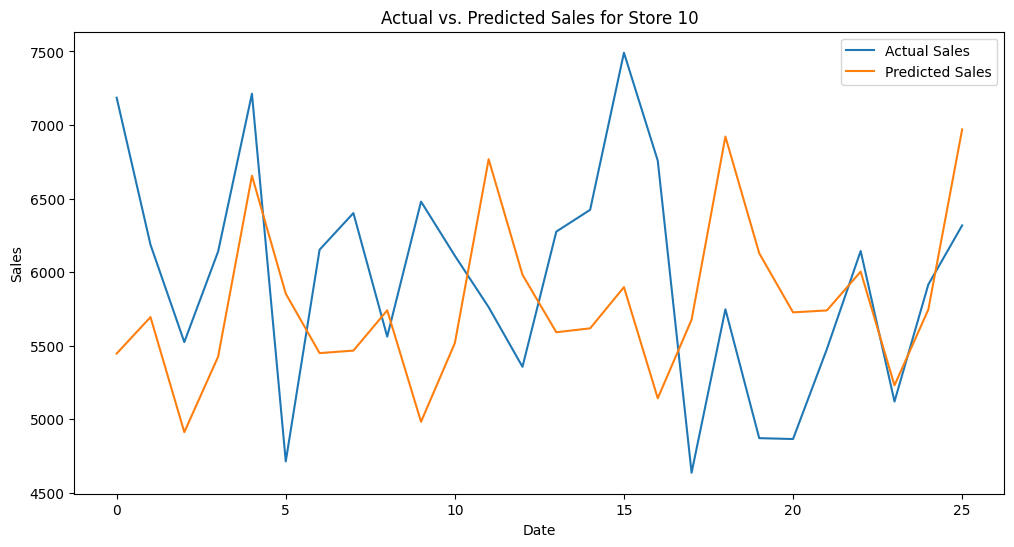

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(actual.index, actual["y"], label="Actual Sales")
plt.plot(predicted.index, predicted["yhat"], label="Predicted Sales")
plt.title(f"Actual vs. Predicted Sales for Store {sid}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

### Prophet Model Components
These plots show the individual components of the Prophet forecast for Store 1, including the overall trend, the weekly seasonality, and the yearly seasonality.

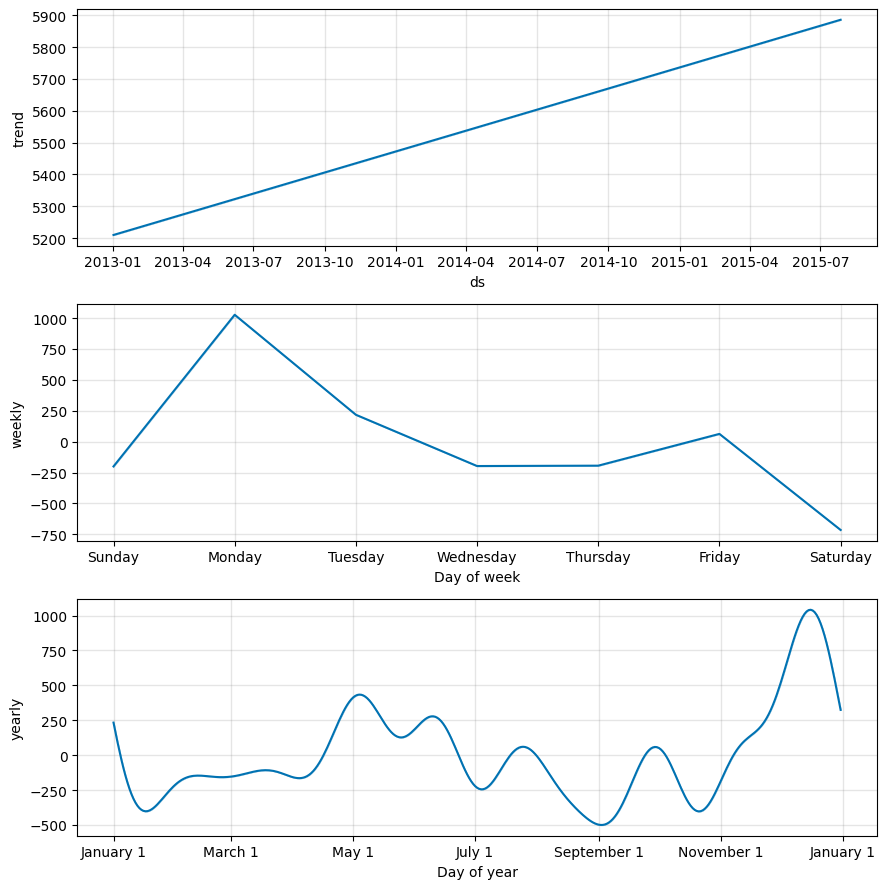

In [23]:
model.plot_components(forecast)
plt.show()

### Distribution of RMSE across First 10 Stores
This box plot visualizes the distribution of the Root Mean Squared Error (RMSE) values calculated for the first 10 stores, providing an overview of the model's performance variability.

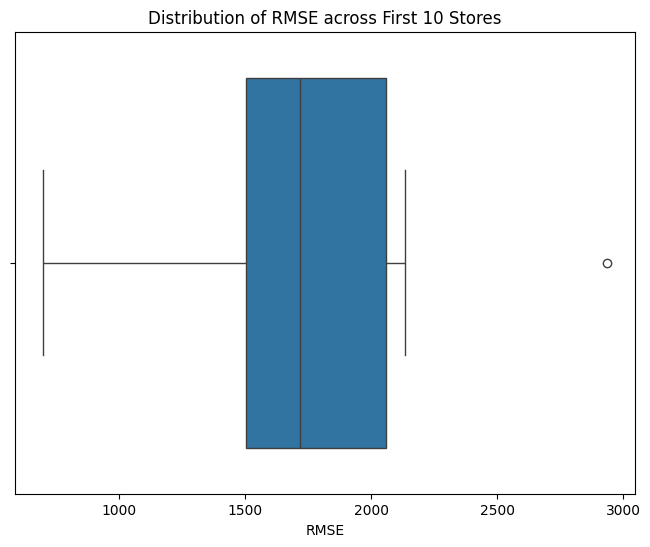

In [24]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=results_df["RMSE"])
plt.title("Distribution of RMSE across First 10 Stores")
plt.xlabel("RMSE")
plt.show()

## Sales Forecasting Performance Report (First 10 Stores)

The Prophet model was used to forecast sales for the first 10 stores in the dataset. The Root Mean Squared Error (RMSE) was used as the evaluation metric to assess the accuracy of the forecasts. A lower RMSE indicates better model performance.

The RMSE values for the first 10 stores are as follows:

| Store | RMSE      |
|-------|-----------|
| 1     | 698.04    |
| 10    | 935.62    |
| 6     | 1446.94   |
| 2     | 1681.54   |
| 4     | 1700.28   |
| 9     | 1733.66   |
| 5     | 1974.78   |
| 3     | 2087.35   |
| 8     | 2133.40   |
| 7     | 2935.31   |

**Key Observations from RMSE:**

*   Store 1 shows the lowest RMSE (698.04), indicating that the Prophet model provided the most accurate sales forecasts for this store among the evaluated set.
*   Store 7 has the highest RMSE (2935.31), suggesting that the model's performance was weakest for this store.
*   There is a significant variation in RMSE across the stores, ranging from approximately 698 to 2935. This indicates that the model's accuracy varies depending on the specific store.

**Insights from Visualizations:**

*   **Store 1 Forecast:** The forecast for Store 1 shows a clear yearly and weekly seasonality, with sales peaking around the end of the year and on Mondays. The model captures the overall trend and seasonality well, although there are some deviations in individual data points.
*   **Actual vs. Predicted Sales (Store 10):** For Store 10, the plot shows that the predicted sales generally follow the trend of the actual sales during the test period. However, there are instances where the model either overestimates or underestimates the sales, particularly around the peaks and troughs.
*   **Prophet Model Components (Store 1):** The component plots for Store 1 clearly illustrate the learned patterns: a generally increasing trend over time, a strong weekly seasonality with higher sales at the beginning of the week, and a yearly seasonality with higher sales towards the end of the year.
*   **Distribution of RMSE across First 10 Stores:** The box plot of RMSE values shows that most of the first 10 stores have an RMSE between approximately 1500 and 2100. There is an outlier with a higher RMSE (Store 7), and a few stores with lower RMSE values (Store 1 and Store 10). This confirms the variability in model performance across different stores.

